In [335]:
import numpy as np
import matplotlib.pyplot as plt

In [336]:
class ray:
    def __init__(self, strenght : float, origin : tuple, dir : tuple, color = 'g'):
        self.strength = strenght
        self.origin = origin
        self.dir = dir
        self.color = color
        self.end_point = None
        self.length = None

    @classmethod
    def from_ray(cls, r, dir, attenuation = 0):
        if r.end_point is None:
            print("Previous ray must be ended before creating a new one")
            return None
        return cls(r.strength * attenuation, r.end_point, dir, r.color)

    def end(self, end_point):
        self.end_point = end_point
        self.length = np.linalg.norm(np.array(self.origin) - np.array(self.end_point))

    def plot(self, plt, color = 'k', alpha = 1, arrow_type = 'small'):
        if self.end_point is not None:
            plt.plot([self.origin[0], self.end_point[0]], [self.origin[1], self.end_point[1]], color=color, alpha=alpha)
        else:
        

            if self.length is None or arrow_type == 'small':
                length = 0.1
            else:
                length = self.length / 2
            
            #draw a small arrow on the origin
            plt.arrow(self.origin[0], self.origin[1], length*self.dir[0], length*self.dir[1], head_width=0.05, head_length=0.05, fc=color, ec=color, alpha=alpha)
        return
        
    @staticmethod
    def from_point(start, n, angle_start=0, angle_end=2*np.pi, color='g'):
        rays = []
        angle = np.linspace(angle_start, angle_end, n)
        for i in range(n):
            rays.append(ray(strenght=1, origin=start, dir=(np.cos(angle[i]), np.sin(angle[i])), color=color))
        return rays
    
    def __str__(self):
        return f"Strenght: {self.strength}, Origin: {self.origin}, Direction: {self.dir}, End: {self.end_point}, Length: {self.length}"

In [337]:
class lens:
    def __init__(self, x : np.array, y : np.array, dx : np.array, refidx_l : float = 1, refidx_r : float = 1, refl_coeff : float = 0, trans_coeff : float = 1):

        self.x = x
        self.y = y
        self.dx = dx

        self.refidx_l = refidx_l
        self.refidx_r = refidx_r

        self.refl_coeff = refl_coeff
        self.trans_coeff = trans_coeff

        self.points = []
        self.segments = []

        self.update()

    def update(self):
        self.points = []
        self.segments = []
        self.calculate_segments()
        self.calculate_points()

    def calculate_points(self):

        for i in range(len(self.x)):
            self.points.append((self.x[i], self.y[i]))

    def calculate_segments(self):

        for i in range(len(self.x)-1):
            self.segments.append(((self.x[i], self.y[i]), (self.x[i+1], self.y[i+1])))

    @classmethod
    def lens_asphere(cls, res : int, R : float, k : float, a : list, refidx_l : float = 1, refidx_r : float = 1, refl_coeff : float = 0, trans_coeff : float = 1):

        # Sample the -1 to 1 range with equidistant points
        y = np.linspace(-1, 1, res)

        sqrt_el = np.sqrt(1 - ((1 + k)*y**2)/R**2)

        # Aspheric lense formula
        x = y**2 / (R * (1 + sqrt_el)) -5

        # Additional terms
        for i in range(len(a)):
            x += a[i] * y**(4 + i*2)

        # Derivative
        #https://www.wolframalpha.com/input?i=derivative+of+x%28y%29+%3D+y%5E2+%2F+%28R+%281+%2B+sqrt%281+-+%28%281+%2B+k%29+y%5E2%29+%2F+R%5E2%29%29%29+%2B+a4+y%5E4+%2B+a6+y%5E6
        dx = 2*y / (R*(sqrt_el + 1)) + ((k + 1) * y**3) / (R**3*(sqrt_el)*(sqrt_el + 1)**2)

        # Additional terms
        for i in range(len(a)):
            dx += (4 + i*2) * a[i] * y**(4 + i*2 - 1)

        # Move the lense to the origin
        x -= min(x)

        return cls(x, y, dx, refidx_l, refidx_r, refl_coeff, trans_coeff)
    
    def get_dx(self, segment, intersection):
            
            # Calculates the distance between the two points of the intersected segment
            # Then interpolates the value of dx at the intersection point
            p1 = np.array(segment[0])
            p2 = np.array(segment[1])

            # Distances between the intersection point and the segment points
            d1 = np.linalg.norm(p1 - intersection)
            d2 = np.linalg.norm(p2 - intersection)

            # Interpolated value of dx over the segment
            dx = self.dx[self.segments.index(segment)] * (d2 / (d1 + d2)) + self.dx[self.segments.index(segment) + 1] * (d1 / (d1 + d2))

            return dx
    
    def ray_intersection(self, r):
            
        def intersect_ray_segment(r, segment):
            # Ray
            o1 = np.array(r.origin)
            d1 = np.array(r.dir)
            # Segment
            o2 = np.array(segment[0])
            d2 = np.array(segment[1]) - np.array(segment[0])
            
            # Calculate intersection point
            cross = np.cross(d1, d2)
            if cross == 0:
                return None
            t1 = np.cross(o2 - o1, d2) / cross
            t2 = np.cross(o2 - o1, d1) / cross
            if t1 >= 0 and t2 >= 0 and t2 <= 1:
                return o1 + t1 * d1
            return None

        intersection = None
        intersected_segment = None

        # Nudge the ray origin to avoid self-intersection
        r.origin = (r.origin[0] + 1e-6 * r.dir[0], r.origin[1] + 1e-6 * r.dir[1])

        for segment in self.segments:
            intersection = intersect_ray_segment(r, segment)
            if intersection is not None:
                return segment, intersection
        
        return None, None
        
    def calculate_trans_dir(self, r, dx): #TODO change name

        # Incoming ray angle
        t0 = np.arctan2(r.dir[1], r.dir[0])

        # Angle of the function in the point
        t1 = np.arctan2(dx, 1)

        # Snell angle (why the exp is zero?)
        t2 = np.arcsin(self.refidx_l * np.sin(t0 + t1) / self.refidx_r)

        # Transmitted direction angle
        t3 =  t2 - t1

        # Resulting transmitted direction
        transm_dir = (np.cos(t3), np.sin(t3))

        # Reflected ray direction direction
        refl_dir = (-np.cos(t0 - 2 * t1), -np.sin(t0 - 2 * t1))

        return refl_dir, transm_dir
    
    def intersect_ray(self, r):

        # Find the *first* segment that intersects with the ray
        segment, intersection = self.ray_intersection(r)

        # If no intersection is found, return None
        if segment == None:
            return None, None
        
        # Close the incoming ray
        r.end(intersection)
        
        # Get the dx in the given point
        dx = self.get_dx(segment, intersection)

        # Calculate the reflected and transmitted directions
        refl_dir, transm_dir = self.calculate_trans_dir(r, dx)

        # Create the two new rays
        transmitted_ray = ray.from_ray(r, transm_dir)
        reflected_ray = ray.from_ray(r, refl_dir)

        return reflected_ray, transmitted_ray

    def plot(self, plt, plot_dx = False, plot_bounding_box = False, **kwargs):

        for el in self.segments:
            plt.plot([el[0][0], el[1][0]], [el[0][1], el[1][1]], **kwargs)

        tmp_dx = self.dx - min(self.dx)

        ratio = max(tmp_dx) / max(self.x)

        tmp_dx  /= ratio

        if plot_dx:
            for i in range(len(self.y)-1):
                plt.plot([tmp_dx[i], tmp_dx[i+1]], [self.y[i], self.y[i+1]], alpha = 0.2, **kwargs)

        if plot_bounding_box:
            alpha = 0.3
            linestyle='dashed'
            plt.plot([0, 0], [min(self.y), max(self.y)], alpha = alpha, linestyle = linestyle, **kwargs)
            plt.plot([max(self.x), max(self.x)], [min(self.y), max(self.y)], alpha = alpha, linestyle = linestyle, **kwargs)
            plt.plot([0, max(self.x)], [min(self.y), min(self.y)], alpha = alpha, linestyle = linestyle, **kwargs)
            plt.plot([0, max(self.x)], [max(self.y), max(self.y)], alpha = alpha, linestyle = linestyle, **kwargs)
            

In [338]:
test_rays = ray.from_point(start=(-1, 0), n=10, angle_start=-0.4, angle_end=0.4, color='red')

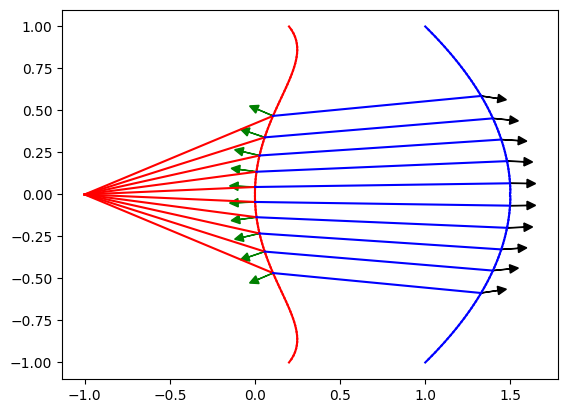

In [339]:
test_lens0 = lens.lens_asphere(res = 100, R = 1, k = -1, a = [0, -0.3], refidx_l=1, refidx_r=1.5)
test_lens1 = lens.lens_asphere(res = 100, R = -1, k = -1, a = [0, 0], refidx_l=1.5, refidx_r=1)

# Kind-of an hack to move the lense
test_lens1.x += 1
test_lens1.update()

plt.figure()

test_lens0.plot(plt, color='red')
test_lens1.plot(plt, color='blue')

r1 = []
t1 = []
t2 = []

for ray in test_rays:
    r, t = test_lens0.intersect_ray(ray)

    r1.append(r)
    t1.append(t)

for ray in t1:
    r, t = test_lens1.intersect_ray(ray)

    t2.append(t)

for ray in test_rays:
    ray.plot(plt, color='red')

for ray in r1:
    ray.plot(plt, color='green')

for ray in t1:
    ray.plot(plt, color='blue')

for ray in t2:
    ray.plot(plt, color='black')


plt.show()